In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SchwiftyNotebook_Annealing")' SchwiftyNotebook_Annealing

Installing packages:
	.package(path: "/home/ubuntu/workspace/fast-ai-swift/SchwiftyNotebook_Annealing")
		SchwiftyNotebook_Annealing
With SwiftPM flags: []
Working in: /tmp/tmp5mgbwfm2/swift-install
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information availabl

[10/11] Merging module jupyterInstalledPackages
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swiftc: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swiftc)
/home/ubuntu/swift/usr/bin/swift-autolink-extract: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift-autolink-extract)
[11/11] Linking libjupyterInstalledPackages.so
Initializing Swift...
Installation complete!


In [2]:
//export
import Path
import TensorFlow
import SchwiftyNotebook_Annealing

## Model

In [3]:
//export
public struct HyperParameters {
    public let learningRate: Float
}

In [4]:
//export
public protocol TeachableModel {
    
    func apply(inputTensor: TensorFloat) -> TensorFloat
    
    func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel)
    
    func backwardsPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> TeachableModel    
}

In [13]:
//export
public protocol ModelParameter_V2  {
    
    func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameter_V2)
    
    func apply(_ inputTensor: TensorFloat) -> TensorFloat 
    
    func backwardPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> (TensorFloat, ModelParameter_V2)
}

In [20]:
//export
public struct DenseLayer_V2: ModelParameter_V2 {
    let activationFunction: SingleInputDifferentiable<TensorFloat>
    let weightParameter: TensorFloat
    let biasParameter: TensorFloat
    private let gradientChain: ThreeInputGradient

    private init(activationFunction: @escaping SingleInputDifferentiable<TensorFloat>,
                 weightParameter: TensorFloat,
                 biasParameter: TensorFloat,
                 gradientChain: @escaping ThreeInputGradient) {
        self.activationFunction = activationFunction
        self.weightParameter = weightParameter
        self.biasParameter = biasParameter
        self.gradientChain = gradientChain
    }

    private init(denseLayer: DenseLayer_V2,
                 gradientChain: @escaping ThreeInputGradient) {
        self.activationFunction = denseLayer.activationFunction
        self.weightParameter = denseLayer.weightParameter
        self.biasParameter = denseLayer.biasParameter
        self.gradientChain = gradientChain
    }

    public init(inputSize: Int,
         outputSize: Int,
         activationFunction: @escaping SingleInputDifferentiable<TensorFloat> = identititySVGC){
        self.activationFunction = activationFunction
        self.weightParameter = TensorFloat(kaimingUniform: TensorShape([inputSize, outputSize]))
        self.biasParameter = TensorFloat(zeros: [outputSize])
        self.gradientChain = { (x: TensorFloat)  in (TensorFloat([1]), TensorFloat([1]), TensorFloat([1]))}
    }

    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameter_V2) {
        let (parameterOutput, parameterGradientChain) =
          linearCombinationAndGradient(inputTensor: inputTensor,
                                       weightParameter: self.weightParameter,
                                       biasParameter: self.biasParameter)
        let (activations, activationsGradientChain) = activationFunction(parameterOutput)

        return (activations, DenseLayer_V2(denseLayer: self,
                                       gradientChain: {ddx in parameterGradientChain(activationsGradientChain(ddx))}))
    }

    public func apply(_ inputTensor: TensorFloat) -> TensorFloat {
        let parameterOutput =
          linearCombination(inputs: inputTensor,
                                       weights: self.weightParameter,
                                       bias: self.biasParameter)
        let (activations, activationsGradientChain) = activationFunction(parameterOutput)
        return activations
    }

    public func backwardPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> 
    (TensorFloat, ModelParameter_V2) {
        let (ddxInput, ddxParameter, ddxBias) = self.gradientChain(ddx)
        return (ddxInput, DenseLayer_V2(activationFunction: activationFunction,
                                    weightParameter: self.weightParameter - hyperParameters.learningRate * ddxParameter,
                                    biasParameter: self.biasParameter - hyperParameters.learningRate * ddxBias,
                                    gradientChain: self.gradientChain))
    }
}

In [21]:
struct SimpleModel : TeachableModel {
    
    private let denseLayer: ModelParameter_V2
    
    private init(denseLayer: ModelParameter_V2){
        self.denseLayer = denseLayer
    }
    
    public init(inputSize: Int, 
                numberOfClasses: Int) {
        denseLayer = DenseLayer_V2(inputSize: inputSize, outputSize: numberOfClasses)
    }
    
    public func apply(inputTensor: TensorFloat) -> TensorFloat {
        return denseLayer.apply(inputTensor)
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel) {
        let (activations, newDenseLayer) = denseLayer.forwardPass(inputTensor: inputTensor)
        return (activations, SimpleModel(denseLayer: newDenseLayer))
    }
    
    public func backwardsPass(ddx: TensorFloat, 
                              hyperParameters: HyperParameters) -> TeachableModel {
        let (ddxDenseLayer, optimizedDenseLayer) = denseLayer.backwardPass(ddx: ddx, 
                                                          hyperParameters: hyperParameters)
        return SimpleModel(denseLayer: optimizedDenseLayer)
    }
}

## Data

In [22]:
//export
public struct DataBunch<T> where T: TensorGroup {
    public let trainingDataset: Dataset<T>
    public let validationDataset: Dataset<T>
}

In [24]:
// export
public struct SupervisedLearningGroup {
    let features: TensorFloat
    let labels: TensorFloat
}

extension SupervisedLearningGroup: TensorGroup {
    
    public static var _typeList: [TensorDataType] = [
        Float.tensorFlowDataType,
        Float.tensorFlowDataType
    ]
    public static var _unknownShapeList: [TensorShape?] = [nil, nil]
    public var _tensorHandles: [_AnyTensorHandle] {
        fatalError("unimplemented")
    }
    public func _unpackTensorHandles(into address: UnsafeMutablePointer<CTensorHandle>?) {
        address!.advanced(by: 0).initialize(to: features.handle._cTensorHandle)
        address!.advanced(by: 1).initialize(to: labels.handle._cTensorHandle)
    }
    public init(_owning tensorHandles: UnsafePointer<CTensorHandle>?) {
        features = Tensor(handle: TensorHandle(_owning: tensorHandles!.advanced(by: 0).pointee))
        labels = Tensor(handle: TensorHandle(_owning: tensorHandles!.advanced(by: 1).pointee))
    }
    public init<C: RandomAccessCollection>(_handles: C) where C.Element: _AnyTensorHandle {
        fatalError("unimplemented")
    }
}

public extension Sequence where Element == SupervisedLearningGroup {
    var first: SupervisedLearningGroup? {
        return first(where: { _ in true })
    }
}

public extension Dataset where Element == SupervisedLearningGroup {
    init(featuresTensor: TensorFloat, labelsTensor: TensorFloat) {
        self.init(elements: SupervisedLearningGroup(
                                                    features: featuresTensor, 
                                                    labels: labelsTensor.expandingShape(at: 1)))
    }
}

In [25]:
import Python

In [26]:
//export
let carDataYCSV = "/home/ubuntu/.machine-learning/data/car_stuff/pakistan_car_labels.csv"
let carDataXCSV = "/home/ubuntu/.machine-learning/data/car_stuff/pakistan_car_x_data.csv"

public let numpy = Python.import("numpy")

func createDataSet(featureTensor: TensorFloat, 
                   labelTensor: TensorFloat, 
                   batchSize: Int) -> Dataset<SupervisedLearningGroup> {
    return Dataset(featuresTensor: featureTensor, labelsTensor: labelTensor)
                    .batched(batchSize)
                    .shuffled(sampleCount: 64, 
                              randomSeed: 69, 
                              reshuffleForEachIterator: true)
}

public func getUsedCarDataBunch(validationSize: Double = 0.2,
                             batchSize: Int = 1028
                            ) -> DataBunch<SupervisedLearningGroup> {
    let usedCarFeaturesArray = numpy.loadtxt(carDataXCSV, 
                                delimiter: ",", 
                                skiprows: 1, 
                                usecols: Array(1...8), 
                                dtype: Float.numpyScalarTypes.first!)
    let categoricalVariableSet: Set = [0,1,2,3,4,5,6,7]
    let continousVariableSet: Set = [-1]
    let usedCarFeatureTensor = reScaleFeatures(featureTensor: TensorFloat(numpy: usedCarFeaturesArray)!, 
                                               catVars: categoricalVariableSet, 
                                               contVars: continousVariableSet)
    
    let usedCarPrices = numpy.loadtxt(carDataYCSV, 
                                delimiter: ",", 
                                skiprows: 0, 
                                usecols: [1], 
                                dtype: Float.numpyScalarTypes.first!)
    let usedCarLabelsTensor = TensorFloat(numpy: usedCarPrices)!
    
    let numberOfUsedCars = usedCarFeatureTensor.shape[0]
    let numberOfUsedCarFeatures = usedCarFeatureTensor.shape[1]
    
    let validationDatasetSize = Int32(floor(validationSize * Double(numberOfUsedCars)))
    let trainingDataSetSize = Int32(numberOfUsedCars) - validationDatasetSize
    
    
    let splitFeatures = usedCarFeatureTensor
                                .split(sizes: Tensor<Int32>([validationDatasetSize, trainingDataSetSize]), 
                                       alongAxis: 0)
    let splitLabels = usedCarLabelsTensor
                            .split(sizes: Tensor<Int32>([validationDatasetSize, trainingDataSetSize]), 
                                   alongAxis: 0)
    
    let validationDataSet = createDataSet(featureTensor: splitFeatures[0],
                                        labelTensor: splitLabels[0], batchSize: batchSize)
    let trainingDataSet = createDataSet(featureTensor: splitFeatures[1],
                                        labelTensor: splitLabels[1], batchSize: batchSize)
    return DataBunch(trainingDataset: trainingDataSet, 
                     validationDataset: validationDataSet)
}

## Teach

In [27]:
//export 
public protocol TeachingDelegate {
    
    func preTeach(epochs: Int)
    
    func postTeach()
    
    func preEpoch(epochNumber: Int, dataSet: Dataset<SupervisedLearningGroup>)
    
    func postEpoch(epochNumber: Int)
    
    func processBatch(model: TeachableModel, 
                      xDataPoints: TensorFloat,
                      yValidationPoints: TensorFloat) -> TeachableModel    
}

In [28]:
let usedCarDataBunch = getUsedCarDataBunch()

In [29]:
//export
public struct Teacher {
    
    private let dataBunch: DataBunch<SupervisedLearningGroup>
    private let trainingDelegate: TeachingDelegate
    private let validationDelegate: TeachingDelegate
    
    
    public func teachModel(model: TeachableModel,
                           numberOfEpochs: Int) -> TeachableModel {
        notifyPreTeach(epochs: numberOfEpochs)
        let taughtModel = (1...numberOfEpochs)
            .reduce(into: model) { (currentModel: inout TeachableModel, 
                                    epoch: Int) in
                let trainedModel = trainModel(modelToTeach: currentModel,
                                              currentEpoch: epoch)
                currentModel = validateModel(modelToValidate: trainedModel,
                                             currentEpoch: epoch)
            }
        notifyPostTeach()
        return taughtModel
    }
    
    private func trainModel(modelToTeach: TeachableModel, 
                            currentEpoch: Int) -> TeachableModel {
        return processDataSet(model: modelToTeach,
                           epoch: currentEpoch,
                           dataSet: dataBunch.trainingDataset,
                           teachingDelegate: trainingDelegate)
    }
    
    private func validateModel(modelToValidate: TeachableModel, 
                               currentEpoch: Int) -> TeachableModel {
        return processDataSet(model: modelToValidate,
                              epoch: currentEpoch,
                              dataSet: dataBunch.validationDataset,
                              teachingDelegate: validationDelegate)
    }
    
    private func processDataSet(model: TeachableModel,
                             epoch: Int,
                             dataSet: Dataset<SupervisedLearningGroup>,
                             teachingDelegate: TeachingDelegate
                            ) -> TeachableModel {
        
        teachingDelegate.preEpoch(epochNumber: epoch, 
                                  dataSet: dataSet)
        
        let taughtModel: TeachableModel = dataSet.reduce(into: model) {
            (currentModel: inout TeachableModel, dataGroup: SupervisedLearningGroup) in
            currentModel = teachingDelegate.processBatch(model: currentModel, 
                                                         xDataPoints: dataGroup.features, 
                                                         yValidationPoints: dataGroup.labels)
        }
        
        teachingDelegate.postEpoch(epochNumber: epoch)
        
        return taughtModel
    }
    
    
    private func notifyPreTeach(epochs: Int) {
        trainingDelegate.preTeach(epochs: epochs)
        validationDelegate.preTeach(epochs: epochs)
    }
    
    private func notifyPostTeach() {
        trainingDelegate.postTeach()
        validationDelegate.postTeach()
    }
}

In [30]:
struct DummyDelegate: TeachingDelegate {
    let name: String
    
    public func postEpoch(epochNumber: Int) {
        print("\(name): Post epoch #\(epochNumber)")
    }
    
    public func preEpoch(epochNumber: Int, 
                         dataSet: Dataset<SupervisedLearningGroup>) {
        print("\(name): pre epoch #\(epochNumber)")
    }
    
    public func preTeach(epochs: Int) {
        print("\(name): pre teach epochs: \(epochs)")
    }
    
    public func postTeach() {
        print("\(name): Post Teach")
    }
    
    
    public func processBatch(model: TeachableModel, 
                             xDataPoints: TensorFloat, 
                             yValidationPoints: TensorFloat) -> TeachableModel {
        print("\(name): processing data with model \(model)")
        return model
    }
    
}

In [31]:
let steve = DummyDelegate(name: "Steve")
let jimmy = DummyDelegate(name: "Jimmy")

In [32]:
let protoTeacher = Teacher(dataBunch: usedCarDataBunch, 
                           trainingDelegate: steve, 
                           validationDelegate: jimmy)

In [33]:
struct DummyModel: TeachableModel {
    let name: String
    
    public func apply(inputTensor: TensorFloat) -> TensorFloat {
        return inputTensor
    }
    
    public func backwardsPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> TeachableModel {
        return self
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel) {
        return (inputTensor, self)
    }
}

In [34]:
let dummyModel = DummyModel(name: "Busty Models 4")

In [35]:
let taughtModel =  protoTeacher.teachModel(model: dummyModel, 
                        numberOfEpochs: 2)

Steve: pre teach epochs: 2
Jimmy: pre teach epochs: 2
Steve: pre epoch #1
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with model DummyModel(name: "Busty Models 4")
Steve: processing data with m

## Teaching Delegates

In [36]:
//export
public protocol LossFunction {
    func lossAndGradient(expectedTensor: TensorFloat,
                         actualTensor: TensorFloat) -> (loss: TensorFloat,
                                                        gradientSupplier: () -> TensorFloat)
    func calculateLoss(expectedTensor: TensorFloat,
                       actualTensor: TensorFloat) -> TensorFloat
}

In [47]:
class ValidationDelegate: TeachingDelegate {
    
    let lossFunction: LossFunction
    
    public init(lossFunction: LossFunction) {
        self.lossFunction = lossFunction
    }
    
    private var epochNumber: Int = 0
    private var numberOfBatches: Int = 0
    private var totalLoss: TensorFloat = TensorFloat([0.0])
    
    public func postEpoch(epochNumber: Int) {
        let loss = totalLoss / Float(numberOfBatches)
        print("Validation Loss for Epoch #\(epochNumber): \(loss)")
    }
    
    public func preEpoch(epochNumber: Int, 
                         dataSet: Dataset<SupervisedLearningGroup>) {
        numberOfBatches = 0
        totalLoss = TensorFloat([0.0])
    }
    
    public func preTeach(epochs: Int) {
    
    }
    
    public func postTeach() {
    
    }
    
    
    public func processBatch(model: TeachableModel, 
                             xDataPoints: TensorFloat, 
                             yValidationPoints: TensorFloat) -> TeachableModel {

        let predictions = model.apply(inputTensor: xDataPoints)
        
        let loss = lossFunction.calculateLoss(expectedTensor: yValidationPoints, 
                                                                    actualTensor: predictions)
        totalLoss += loss
        numberOfBatches += 1
        
        return model
    }
    
}

In [127]:
class TrainingDelegate: TeachingDelegate {
    
    let lossFunction: LossFunction
    
    public init(lossFunction: LossFunction) {
        self.lossFunction = lossFunction
    }
    
    private var epochNumber: Int = 0
    private var numberOfBatches: Int = 0
    private var totalLoss: TensorFloat = TensorFloat([0.0])
    
    public func postEpoch(epochNumber: Int) {
        let loss = totalLoss / Float(numberOfBatches)
        print("Training Loss for Epoch #\(epochNumber): \(loss)")
    }
    
    public func preEpoch(epochNumber: Int, 
                         dataSet: Dataset<SupervisedLearningGroup>) {
        numberOfBatches = 0
        totalLoss = TensorFloat([0.0])
    }
    
    public func preTeach(epochs: Int) {
    
    }
    
    public func postTeach() {
    
    }
    
    
    public func processBatch(model: TeachableModel, 
                             xDataPoints: TensorFloat, 
                             yValidationPoints: TensorFloat) -> TeachableModel {

        let (predictions, modelWithChain) = model.forwardPass(inputTensor: xDataPoints)
        
        let (loss, gradientSupplier) = lossFunction.lossAndGradient(expectedTensor: yValidationPoints, 
                                                                    actualTensor: predictions)
        
        totalLoss += loss
        numberOfBatches += 1
        
        // todo: Optimize Hyper Parameters beforehand
        let hyperParameters = HyperParameters(learningRate: 1e-3)
        
        return modelWithChain.backwardsPass(ddx: gradientSupplier(),
                                            hyperParameters: hyperParameters)
    }
    
}

In [111]:
//export
public struct MeanSquaredErrorLossFunction: LossFunction {
        
    public func calculateLoss(expectedTensor: TensorFloat, 
                              actualTensor: TensorFloat) -> TensorFloat {
        let error: TensorFloat = calculateError(expectedTensor: expectedTensor,
                                   actualTensor: actualTensor)
        return error.squared().mean()
    }
    
    public func lossAndGradient(expectedTensor: TensorFloat, 
                                actualTensor: TensorFloat) -> (loss: TensorFloat, gradientSupplier: () -> TensorFloat) {
        let error = calculateError(expectedTensor:expectedTensor, 
                                   actualTensor: actualTensor)
        let (squareValue, squareGradient) = squaredWithGradient(inputTensor: error)
        let (meanValue, meanGradient) = meanWithGradient(inputTensor: squareValue)

        return (loss: meanValue, gradientSupplier: { squareGradient(meanGradient(TensorFloat([1]))) })
    }
    
    private func calculateError(expectedTensor: TensorFloat,
                                actualTensor: TensorFloat) -> TensorFloat {
        assert(expectedTensor.shape == actualTensor.shape, "Expected \(expectedTensor.shape) to be the same as \(actualTensor.shape)")
        return expectedTensor - actualTensor
    }
}

In [128]:
let meanSquaredErrorLossy = MeanSquaredErrorLossFunction()
let protoTrainingDelegate = TrainingDelegate(lossFunction: meanSquaredErrorLossy)
let protoValidationDelegate = ValidationDelegate(lossFunction: meanSquaredErrorLossy)

In [113]:
let protoModelTeacher = Teacher(dataBunch: usedCarDataBunch, 
                                trainingDelegate: protoTrainingDelegate, 
                                validationDelegate: protoValidationDelegate)

In [77]:
let firstValidationBatch = usedCarDataBunch.validationDataset.first!
let simpleUntrainedModel = SimpleModel(inputSize: firstValidationBatch.features.shape[1], 
                                       numberOfClasses: 1)
simpleUntrainedModel

▿ SimpleModel
  ▿ denseLayer : DenseLayer_V2
    - activationFunction : (Function)
    - weightParameter : [[   0.1691068],
 [-0.027010033],
 [  0.19487487],
 [  0.56515175],
 [ -0.38063496],
 [  0.28339213],
 [ -0.49882752],
 [  -0.5168968]]
    - biasParameter : [0.0]
    - gradientChain : (Function)


In [78]:
let predictions = simpleUntrainedModel.apply(inputTensor: firstValidationBatch.features)
meanSquaredErrorLossy.calculateLoss(expectedTensor: firstValidationBatch.labels, 
                                    actualTensor: predictions)

1.635975e+12


In [79]:
let simpleTrainedModel = protoModelTeacher.teachModel(model: simpleUntrainedModel, 
                                                      numberOfEpochs: 20)

Training Loss for Epoch #1: [3.648939e+12]
Validation Loss for Epoch #1: [1.7118584e+12]
Training Loss for Epoch #2: [3.8139986e+12]
Validation Loss for Epoch #2: [1.8787525e+12]
Training Loss for Epoch #3: [4.0080677e+12]
Validation Loss for Epoch #3: [2.0761235e+12]
Training Loss for Epoch #4: [4.2362512e+12]
Validation Loss for Epoch #4: [2.3094304e+12]
Training Loss for Epoch #5: [4.5045577e+12]
Validation Loss for Epoch #5: [2.585104e+12]
Training Loss for Epoch #6: [4.820045e+12]
Validation Loss for Epoch #6: [2.910714e+12]
Training Loss for Epoch #7: [5.191019e+12]
Validation Loss for Epoch #7: [3.2951724e+12]
Training Loss for Epoch #8: [5.627245e+12]
Validation Loss for Epoch #8: [3.748969e+12]
Training Loss for Epoch #9: [6.140207e+12]
Validation Loss for Epoch #9: [4.2844537e+12]
Training Loss for Epoch #10: [6.74341e+12]
Validation Loss for Epoch #10: [4.9161605e+12]
Training Loss for Epoch #11: [7.452737e+12]
Validation Loss for Epoch #11: [5.6611937e+12]
Training Loss for

In [66]:
simpleTrainedModel

▿ SimpleModel
  ▿ denseLayer : DenseLayer_V2
    - activationFunction : (Function)
    - weightParameter : [[ -5.303766e+11],
 [-6.3852564e+11],
 [-1.2830816e+12],
 [ -5.591481e+11],
 [ -3.520645e+11],
 [-4.2251574e+11],
 [-3.4479724e+12],
 [-4.3088495e+10]]
    - biasParameter : [-3.7833823e+12]
    - gradientChain : (Function)


In [85]:
let simpleDenseLayer = DenseLayer_V2(inputSize: firstValidationBatch.features.shape[1], 
                                     outputSize: 1,
                                    activationFunction: reLUAndGradient)

In [88]:
var currentDenseLayer: ModelParameter_V2 = simpleDenseLayer
let trialsHyperParameter = HyperParameters(learningRate: 1e-1)
withTime {
    var trial = 0
    timeTrials(trials: 200) { 
        var accumulatedTrainingLoss = TensorFloat([0])
        var trainingItems = TensorFloat([0])
        for batch in usedCarDataBunch.trainingDataset {
            let (alexYHat, alexLayer) = currentDenseLayer.forwardPass(inputTensor: batch.features)
            
            let (loss, lossGradientSupplier) = meanSquaredErrorAndGradient(yHat: alexYHat, 
                                                                           y:batch.labels)
            accumulatedTrainingLoss += loss
            trainingItems += 1
            
            let (ddxAlexLayer, enhancedLayer) = alexLayer.backwardPass(ddx: lossGradientSupplier(), 
                                                                       hyperParameters: trialsHyperParameter)
            currentDenseLayer = enhancedLayer   
        }
        
        
        var accumulatedValidationLoss = TensorFloat([0])
        var validationItems = TensorFloat([0])
        for validationBatch in usedCarDataBunch.validationDataset {
            let (validationLoss, _) = meanSquaredErrorAndGradient(yHat: currentDenseLayer.apply(validationBatch.features), 
                                                                  y: validationBatch.labels)
            
            accumulatedValidationLoss += validationLoss
            validationItems += 1
        }
        
        if(trial % 10 == 0) {
            print("Training Loss: \(accumulatedTrainingLoss/trainingItems)")
            print("Validation Loss: \(accumulatedValidationLoss/validationItems)")   
        }
        trial += 1
    }
}

Training Loss: [2.8300977e+12]
Validation Loss: [8.1882546e+11]
Training Loss: [2.6013163e+12]
Validation Loss: [7.560932e+11]
Training Loss: [2.5826526e+12]
Validation Loss: [7.473717e+11]
Training Loss: [2.576225e+12]
Validation Loss: [7.439271e+11]
Training Loss: [2.5727745e+12]
Validation Loss: [7.41511e+11]
Training Loss: [2.570403e+12]
Validation Loss: [7.396255e+11]
Training Loss: [2.5685275e+12]
Validation Loss: [7.3796066e+11]
Training Loss: [2.5671023e+12]
Validation Loss: [7.3652044e+11]
Training Loss: [2.565997e+12]
Validation Loss: [7.35367e+11]
Training Loss: [2.5650793e+12]
Validation Loss: [7.342473e+11]
Training Loss: [2.5643602e+12]
Validation Loss: [7.3341934e+11]
Training Loss: [2.5637374e+12]
Validation Loss: [7.326458e+11]
Training Loss: [2.563157e+12]
Validation Loss: [7.318186e+11]
Training Loss: [2.5625826e+12]
Validation Loss: [7.310463e+11]
Training Loss: [2.561831e+12]
Validation Loss: [7.302857e+11]
Training Loss: [2.561192e+12]
Validation Loss: [7.295248e+

In [89]:
currentDenseLayer

▿ DenseLayer_V2
  - activationFunction : (Function)
  - weightParameter : [[-1362714.8],
 [ 1141372.4],
 [-944537.56],
 [ 1818164.8],
 [ 671667.25],
 [-1286894.8],
 [-1140293.8],
 [ -682291.3]]
  - biasParameter : [2017634.4]
  - gradientChain : (Function)


In [90]:
let n = 100
let inputPoints = TensorFloat(randomNormal: [100, 1])
let A = inputPoints.concatenated(with: TensorFloat(ones: inputPoints.shape), alongAxis: 1)
A.shape

▿ [100, 2]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 2


In [91]:
let yValidationPoints = matmul(A, TensorFloat([-2, 7]).expandingShape(at: 1)) + 
                (TensorFloat(randomNormal: inputPoints.shape, seed: (69, 420)) * 2.5)
yValidationPoints.shape

▿ [100, 1]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 1


In [92]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [93]:
public let plotter = Python.import("matplotlib.pyplot")

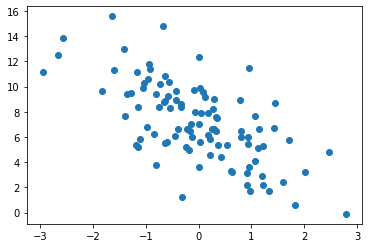

None


In [94]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
plotter.show()

In [95]:
func showYHat(yHat: TensorFloat) {
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yHat.makeNumpyArray())
    plotter.show()
}

In [99]:
let linearModel = SimpleModel(inputSize: 2, 
                              numberOfClasses: 1)

In [100]:
linearModel

▿ SimpleModel
  ▿ denseLayer : DenseLayer_V2
    - activationFunction : (Function)
    - weightParameter : [[0.285774],
 [0.676579]]
    - biasParameter : [0.0]
    - gradientChain : (Function)


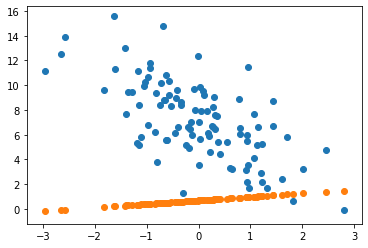

In [101]:
showYHat(yHat: linearModel.apply(inputTensor: A))

In [123]:
let pointGroup = createDataSet(featureTensor: A, 
                               labelTensor: yValidationPoints.squeezingShape(at: 1), 
                               batchSize: 10)
let sillyDataBunch = DataBunch(trainingDataset: pointGroup,
                               validationDataset: pointGroup)

In [129]:
let pointTeacher = Teacher(dataBunch: sillyDataBunch, 
                           trainingDelegate: protoTrainingDelegate, 
                           validationDelegate: protoValidationDelegate)

In [130]:
let taughtLinearModel = pointTeacher.teachModel(model: linearModel, 
                                                numberOfEpochs: 10)

Training Loss for Epoch #1: [55.589703]
Validation Loss for Epoch #1: [57.756207]
Training Loss for Epoch #2: [59.59374]
Validation Loss for Epoch #2: [61.936268]
Training Loss for Epoch #3: [63.923958]
Validation Loss for Epoch #3: [66.45698]
Training Loss for Epoch #4: [68.607185]
Validation Loss for Epoch #4: [71.34637]
Training Loss for Epoch #5: [73.67249]
Validation Loss for Epoch #5: [76.634796]
Training Loss for Epoch #6: [79.15132]
Validation Loss for Epoch #6: [82.35512]
Training Loss for Epoch #7: [85.07773]
Validation Loss for Epoch #7: [88.54292]
Training Loss for Epoch #8: [91.48863]
Validation Loss for Epoch #8: [95.23673]
Training Loss for Epoch #9: [98.423935]
Validation Loss for Epoch #9: [102.47827]
Training Loss for Epoch #10: [105.9269]
Validation Loss for Epoch #10: [110.31272]


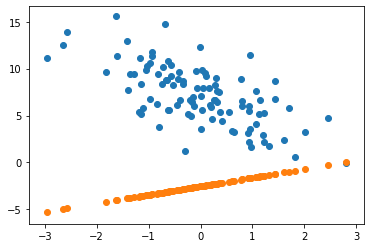

In [131]:
showYHat(yHat: taughtLinearModel.apply(inputTensor: A))